# Installing needed packages

In [1]:
!pip uninstall -y yawbcc
!pip -q install git+https://github.com/corralien/yawbcc.git 2> /dev/null

Found existing installation: yawbcc 0.1.2
Uninstalling yawbcc-0.1.2:
  Successfully uninstalled yawbcc-0.1.2


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib

2022-11-17 23:27:50.724971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import data

In [2]:
from yawbcc.datasets import load_barcelona_wbc
# creation of DataFrame
df = load_barcelona_wbc()
df.head()

,image,group,label,width,height,path
0,BA_689200.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
1,BA_883452.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
2,BA_382161.jpg,BASOPHIL,BA,366,369,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
3,BA_175579.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...
4,BA_775722.jpg,BASOPHIL,BA,360,363,/Users/Anastasiya/yawbcc_data/barcelona/basoph...


In [3]:
DATA_DIR = pathlib.Path.home() / 'yawbcc_data'

BATCH_SIZE = 32
IMG_SIZE = (128, 128)


train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='training', seed=2022,
                                        image_size=IMG_SIZE, batch_size=BATCH_SIZE, crop_to_aspect_ratio=True)

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR / 'barcelona', validation_split=0.2, subset='validation', seed=2022,
                                        image_size=IMG_SIZE, batch_size=BATCH_SIZE, crop_to_aspect_ratio=True)

# As the original dataset doesn't contain a test set, you will create one.
#To do so, determine how many batches of data are available in the validation set using
# tf.data.experimental.cardinality, then move 20% of them to a test set.

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
# Names of the clases
class_names = train_ds.class_names
# Number of classes
num_classes=len(class_names)
print('Class names:',class_names)
print('Number of classes:',num_classes)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.


2022-11-17 23:28:09.148549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 17092 files belonging to 8 classes.
Using 3418 files for validation.
Number of validation batches: 86
Number of test batches: 21
Number of train batches: 428
Class names: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
Number of classes: 8


# Image visualisation

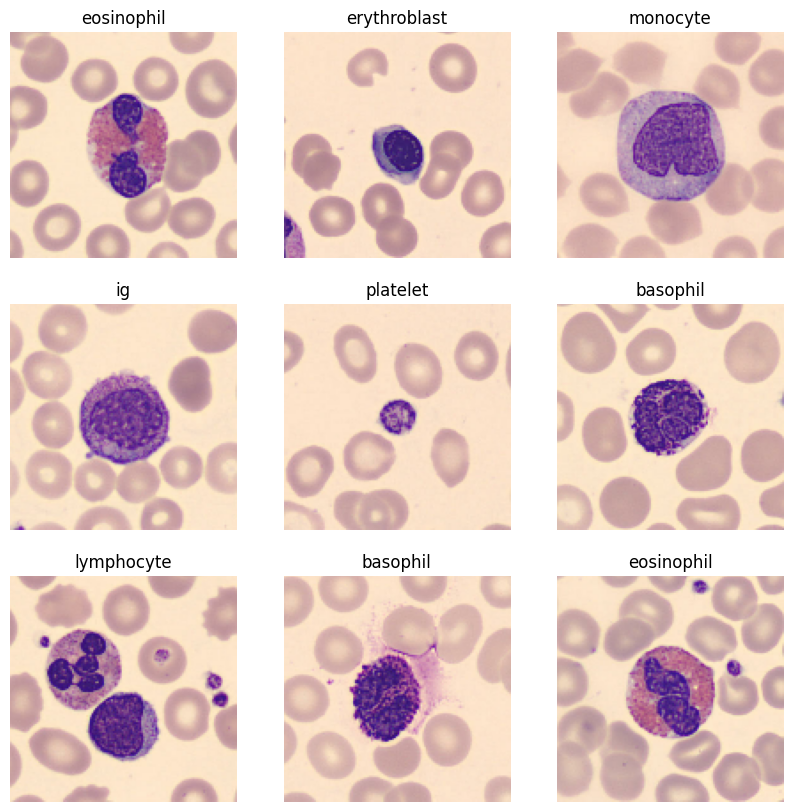

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Configurating the dataset for performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model LeNet

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model_leNet = Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),    
    layers.Conv2D(filters=30, kernel_size=(5,5), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(rate=0.2),
    layers.Flatten(),
    layers.Dense(units = 128, activation ='relu'),            
    layers.Dense(units = num_classes, activation ='softmax') ])           

model_leNet.compile(loss = "SparseCategoricalCrossentropy", optimizer = 'adam', metrics = ['accuracy'])

model_leNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 30)      2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 16)        0

# Model training

In [8]:
epochs=20
history = model_leNet.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
428/428 [==============================] - 96s 210ms/step - loss: 0.9762 - accuracy: 0.6493 - val_loss: 0.4828 - val_accuracy: 0.8434
Epoch 2/20
428/428 [==============================] - 89s 209ms/step - loss: 0.4520 - accuracy: 0.8423 - val_loss: 0.3331 - val_accuracy: 0.8878
Epoch 3/20
428/428 [==============================] - 89s 207ms/step - loss: 0.3236 - accuracy: 0.8872 - val_loss: 0.3275 - val_accuracy: 0.8813
Epoch 4/20
428/428 [==============================] - 89s 208ms/step - loss: 0.2663 - accuracy: 0.9058 - val_loss: 0.3122 - val_accuracy: 0.8966
Epoch 5/20
428/428 [==============================] - 94s 220ms/step - loss: 0.2217 - accuracy: 0.9228 - val_loss: 0.2213 - val_accuracy: 0.9301
Epoch 6/20
428/428 [==============================] - 92s 215ms/step - loss: 0.1754 - accuracy: 0.9407 - val_loss: 0.2687 - val_accuracy: 0.9104
Epoch 7/20
428/428 [==============================] - 91s 212ms/step - loss: 0.1514 - accuracy: 0.9461 - val_loss: 0.2251 - val_ac

# Evaluation: Plotting learning curves

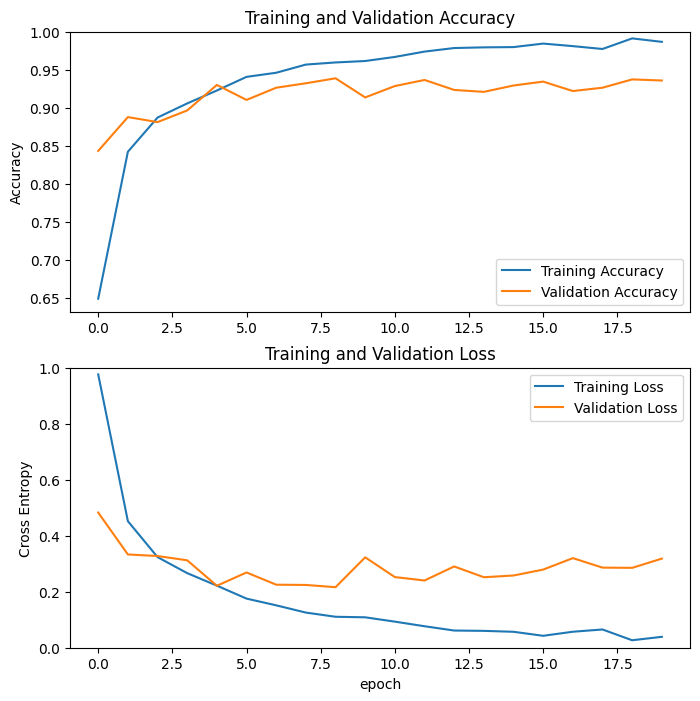

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Plotting images with predictions

Predictions:
 [6 7 6 6 1 2 3 7 4 5 1 7 1 5 5 3 3 4 1 6 3 2 1 3 6 3 6 3 7 6 7 7]
Labels:
 [6 7 6 6 1 2 3 2 4 5 1 7 1 5 5 0 5 4 1 6 0 2 1 3 6 3 6 3 7 6 7 7]


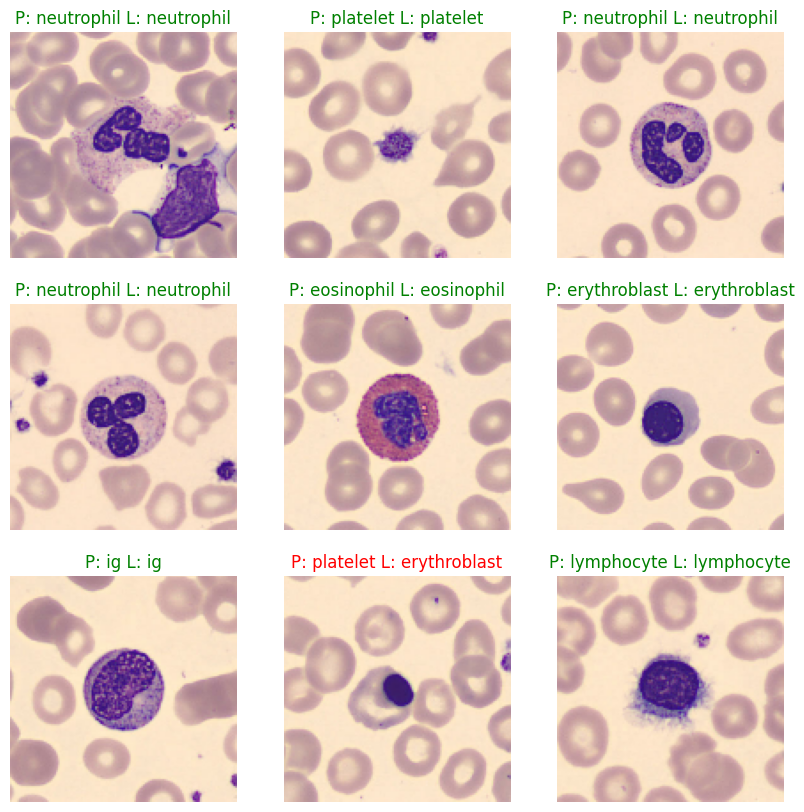

In [13]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_leNet.predict_on_batch(image_batch).argmax(axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    if predictions[i]== label_batch[i]:
        color='g'
    else:
        color='r'
    plt.title(f'P: {class_names[predictions[i]]} L: {class_names[label_batch[i]]}',c=color)
    plt.axis("off")

# Classification report and Confusion Matrics

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

L_true=[] # true labels of test_ds; it is a list os lists, eaach elemnt is a list coresponding to a BATCH
P=[] # predictions on test_ds; it is a list os lists, eaach elemnt is a list coresponding to a BATCH
for element in test_ds.as_numpy_iterator(): 
    image_batch, label_batch = test_ds.as_numpy_iterator().next() # iteration batch by batch
    predictions = model_leNet.predict_on_batch(image_batch).argmax(axis=1) # predictions
    L_true.append(label_batch) # addition to the list 
    P.append(predictions)  # addition to the list 

all_L_true = np.concatenate(L_true) # getting a LIST of true labes od test_ds from list of lists
all_P = np.concatenate(P) # # getting a LIST of true labes od test_ds from list of lists

# classification report
print(classification_report(all_L_true,all_P))

# confusion matrix
conf_matrix_ft_ALL=confusion_matrix(all_L_true,all_P)
print(conf_matrix_ft_ALL)

              precision    recall  f1-score   support

           0       0.98      0.79      0.87        52
           1       0.95      1.00      0.97       130
           2       0.72      0.82      0.77        34
           3       0.81      0.81      0.81       100
           4       1.00      0.89      0.94        46
           5       0.98      0.84      0.90        56
           6       0.92      0.96      0.94       158
           7       0.95      1.00      0.97        96

    accuracy                           0.92       672
   macro avg       0.91      0.89      0.90       672
weighted avg       0.92      0.92      0.91       672

[[ 41   4   0   5   0   0   2   0]
 [  0 130   0   0   0   0   0   0]
 [  0   0  28   1   0   0   0   5]
 [  1   0   7  81   0   0  11   0]
 [  0   0   4   0  41   1   0   0]
 [  0   0   0   9   0  47   0   0]
 [  0   3   0   4   0   0 151   0]
 [  0   0   0   0   0   0   0  96]]


<AxesSubplot: >

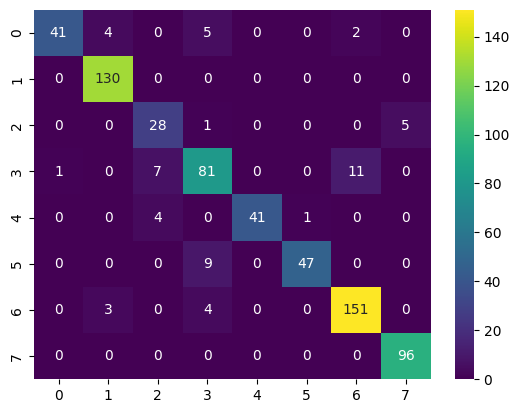

In [23]:
import seaborn as sns
sns.heatmap(conf_matrix_ft_ALL, cmap='viridis',annot=True,fmt='01')

In [24]:
class_names

['basophil',
 'eosinophil',
 'erythroblast',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']